# 1) Dataset

As bases de dados utilizadas são provenientes do **Banco Central do Brasil (BCB)**, mais especificamente do **Sistema Gerenciador de Séries Temporais (SGS)** e da tabela de **Metas da Taxa Selic**.

### Fontes de dados:
- **Sistema Gerenciador de Séries Temporais (SGS/BCB):**  
  [Acessar SGS/BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

- **Metas de taxa para a Selic:**  
  [Acessar Metas da Selic](https://www.bcb.gov.br/estatisticas/detalhamentoGrafico/graficosestatisticas/metaselic)

- **Tabela de estatísticas monetárias e de crédito**  
  (contém as séries administradas pelo SGS em formato `.xlsx`):  
  [Acessar estatísticas monetárias e de crédito](https://www.bcb.gov.br/estatisticas/estatisticasmonetariascredito)


## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [1]:
import time
import math
import requests  # cliente HTTP
import pandas as pd
from datetime import datetime
from pathlib import Path

URL_BASE = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados"

def baixar_sgs(codigo: int, data_inicial: str, data_final: str, tentativas_max: int = 5) -> pd.DataFrame:
    """
    Baixa UMA série do SGS em JSON e devolve DataFrame com colunas: ['dt', f'sgs_{codigo}'].
    data_inicial/data_final no formato 'dd/mm/aaaa'. Backoff simples em caso de erro HTTP.
    """
    parametros = {"formato": "json", "dataInicial": data_inicial, "dataFinal": data_final}
    for tentativa in range(tentativas_max):
        try:
            resp = requests.get(URL_BASE.format(codigo=codigo), params=parametros, timeout=30)
            resp.raise_for_status()
            dados = resp.json()
            df = pd.DataFrame(dados)
            if df.empty:
                return pd.DataFrame(columns=["dt", f"sgs_{codigo}"])
            # Converte data (pode vir dd/mm/aaaa ou mm/aaaa)
            def parsear_data(s):
                for fmt in ("%d/%m/%Y", "%m/%Y"):
                    try:
                        return datetime.strptime(s, fmt)
                    except ValueError:
                        pass
                return pd.NaT
            df["dt"] = df["data"].apply(parsear_data)
            df[f"sgs_{codigo}"] = pd.to_numeric(df["valor"].str.replace(",", "."), errors="coerce")
            saida = df[["dt", f"sgs_{codigo}"]].dropna(subset=["dt"]).copy()
            # normaliza para frequência mensal (MS)
            saida = (
                saida.set_index("dt")
                     .sort_index()
                     .asfreq("MS")  # Month Start
                     .ffill()       # preenche mês faltante com último valor
            )
            saida.reset_index(inplace=True)
            return saida
        except requests.RequestException as e:
            espera = 2 ** tentativa
            time.sleep(espera)
            if tentativa == tentativas_max - 1:
                raise e

def baixar_varias(codigos: list[int], data_inicial: str, data_final: str) -> pd.DataFrame:
    """
    Faz merge (outer) de várias séries por 'dt'. Retorna DataFrame com dt + colunas sgs_XXXX.
    """
    df_todas = None
    for codigo in codigos:
        df_serie = baixar_sgs(codigo, data_inicial, data_final)
        df_todas = df_serie if df_todas is None else df_todas.merge(df_serie, on="dt", how="outer")
    # index mensal e ordenação
    return df_todas.set_index("dt").sort_index().asfreq("MS")

# conjuntos de séries que serão utilizadas na análise
CODIGOS_LIVRES = [20635, 20662, 20634, 20718, 20740, 20717, 20787, 20809, 20786]
CODIGOS_ICC_LIVRES = [25355, 25356, 25354]  # opcional

CODIGOS_DIRECIONADOS = [20686, 20698, 20685, 20757, 20768, 20756, 20826, 20837, 20825]
CODIGOS_ICC_DIRECIONADOS = [25358, 25359, 25357]  # opcional

INCLUIR_ICC = True
CODIGOS_LIVRES_FINAIS = CODIGOS_LIVRES + (CODIGOS_ICC_LIVRES if INCLUIR_ICC else [])
CODIGOS_DIRECIONADOS_FINAIS = CODIGOS_DIRECIONADOS + (CODIGOS_ICC_DIRECIONADOS if INCLUIR_ICC else [])

# datas-alvo
DATA_INICIAL = "01/01/2016"
DATA_FINAL = datetime.today().strftime("%d/%m/%Y")

# baixa e organiza 
df_livres = baixar_varias(CODIGOS_LIVRES_FINAIS, DATA_INICIAL, DATA_FINAL)
df_direcionados = baixar_varias(CODIGOS_DIRECIONADOS_FINAIS, DATA_INICIAL, DATA_FINAL)


conjunto_dados = df_livres.join(df_direcionados, how="outer")

conjunto_dados


,sgs_20635,sgs_20662,sgs_20634,sgs_20718,sgs_20740,sgs_20717,sgs_20787,sgs_20809,sgs_20786,sgs_25355,...,sgs_20685,sgs_20757,sgs_20768,sgs_20756,sgs_20826,sgs_20837,sgs_20825,sgs_25358,sgs_25359,sgs_25357
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01,97151,103508,200658,31.34,65.80,48.78,16.81,50.02,33.62,25.21,...,20433,11.62,9.94,10.71,4.29,3.65,3.94,8.41,8.48,8.44
2016-02-01,99433,106054,205487,31.72,67.33,49.88,17.51,52.10,35.15,25.57,...,20736,11.78,9.69,10.64,4.48,3.56,3.98,8.44,8.51,8.47
2016-03-01,118772,112509,231281,30.66,68.57,50.07,17.60,54.39,36.44,25.66,...,29000,11.89,10.13,10.93,4.56,3.76,4.12,8.52,8.55,8.53
2016-04-01,105583,106139,211721,30.68,70.42,51.21,17.81,56.98,38.05,25.78,...,27932,11.54,10.03,10.71,4.21,3.77,3.97,8.56,8.58,8.57
2016-05-01,112566,114529,227095,29.89,70.70,51.12,17.69,57.69,38.50,25.61,...,27227,11.81,10.46,11.07,4.43,4.00,4.20,8.59,8.63,8.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01,259516,301404,560920,23.47,56.77,43.86,9.75,42.30,29.68,20.60,...,59003,18.32,11.37,12.92,5.09,4.47,4.61,10.97,9.54,10.01
2025-04-01,263452,309881,573332,24.21,58.01,45.01,10.65,43.75,31.02,20.88,...,70925,15.85,11.14,12.21,4.35,4.47,4.44,11.14,9.57,10.09
2025-05-01,271402,307525,578928,24.17,58.70,45.64,10.76,44.71,31.87,20.93,...,68547,14.67,11.27,12.04,4.50,4.46,4.47,11.21,9.60,10.14


## Transposição da base: As séries serão linhas e as colunas as datas (mês/ano)

In [2]:
# 1) Garantir ordenação por data e formato amigável do rótulo de coluna (datas)
conjunto_dados = conjunto_dados.sort_index()
rotulos_datas = [dt.strftime("%Y-%m") for dt in conjunto_dados.index]

# 2) Transpor: linhas = séries, colunas = datas
tabela_series = conjunto_dados.T.copy()
tabela_series.columns = rotulos_datas

# 3) (Opcional) Renomear o índice (nome das linhas) para algo mais intuitivo
tabela_series.index.name = "Série"

tabela_series

,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Série,,,,,,,,,,,,,,,,,,,,,
sgs_20635,97151.00,99433.00,118772.00,105583.00,112566.00,115862.00,95447.00,102841.00,110601.00,101911.00,...,257922.00,253835.00,310403.00,238004.00,237764.00,259516.00,263452.00,271402.00,264523.00,253797.00
sgs_20662,103508.00,106054.00,112509.00,106139.00,114529.00,113802.00,110430.00,119029.00,108839.00,114147.00,...,309554.00,302438.00,316382.00,302714.00,292589.00,301404.00,309881.00,307525.00,304322.00,317637.00
sgs_20634,200658.00,205487.00,231281.00,211721.00,227095.00,229664.00,205877.00,221869.00,219440.00,216059.00,...,567476.00,556273.00,626785.00,540718.00,530276.00,560920.00,573332.00,578928.00,568844.00,571434.00
sgs_20718,31.34,31.72,30.66,30.68,29.89,30.04,30.32,30.50,29.51,30.24,...,21.38,21.66,21.73,24.13,23.78,23.47,24.21,24.17,24.29,25.02
sgs_20740,65.80,67.33,68.57,70.42,70.70,70.18,70.75,71.15,72.61,72.87,...,52.39,53.16,53.11,54.28,56.64,56.77,58.01,58.70,58.42,57.65
sgs_20717,48.78,49.88,50.07,51.21,51.12,50.93,51.60,52.10,52.43,53.06,...,40.17,40.86,40.74,42.46,43.85,43.86,45.01,45.64,45.51,45.40
sgs_20787,16.81,17.51,17.60,17.81,17.69,17.86,18.29,18.40,17.65,18.55,...,9.82,9.62,8.56,10.61,10.22,9.75,10.65,10.76,10.91,11.61
sgs_20809,50.02,52.10,54.39,56.98,57.69,57.25,58.05,58.51,60.09,60.82,...,40.25,40.54,39.25,39.90,42.35,42.30,43.75,44.71,44.40,43.64
sgs_20786,33.62,35.15,36.44,38.05,38.50,38.36,39.21,39.71,40.22,41.18,...,28.26,28.46,27.16,28.42,29.84,29.68,31.02,31.87,31.73,31.61


# Mapa de Séries do Bacen (SGS)

As séries foram organizadas em dois grandes grupos: **Recursos Livres (RL)** e **Recursos Direcionados (RD)**.  
Cada grupo contém informações sobre **concessões de crédito**, **taxas de juros médias**, **spreads bancários** e o **Índice de Custo de Crédito (ICC)**, separados por **Pessoa Jurídica (PJ)**, **Pessoa Física (PF)** e **Total (TOT)**.

---

## 📌 Recursos Livres (RL)

Recursos livres são operações de crédito em que as instituições financeiras têm maior liberdade para definir taxas, prazos e condições, sem vinculação legal obrigatória.

### Concessões de Crédito
- **sgs_20635 → concessoes_RL_PJ**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Jurídica**.  
- **sgs_20662 → concessoes_RL_PF**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Física**.  
- **sgs_20634 → concessoes_RL_TOT**  
  Total de concessões de crédito em recursos livres (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20718 → taxa_RL_PJ**  
  Taxa de juros média das operações de crédito com recursos livres para **PJ**.  
- **sgs_20740 → taxa_RL_PF**  
  Taxa de juros média das operações de crédito com recursos livres para **PF**.  
- **sgs_20717 → taxa_RL_TOT**  
  Taxa de juros média consolidada das operações de crédito com recursos livres.  

### Spread Bancário  
(O spread representa a diferença entre a taxa de juros cobrada do tomador e o custo de captação do banco.)  
- **sgs_20787 → spread_RL_PJ**  
  Spread das operações de crédito com recursos livres para **PJ**.  
- **sgs_20809 → spread_RL_PF**  
  Spread das operações de crédito com recursos livres para **PF**.  
- **sgs_20786 → spread_RL_TOT**  
  Spread médio consolidado em recursos livres.  

### Índice de Custo de Crédito (ICC)  
(O ICC mede o **custo médio do crédito no Brasil**, ponderando diferentes modalidades de crédito. Funciona como um indicador sintético do preço do crédito, semelhante a como o IPCA resume preços.)  
- **sgs_25355 → icc_RL_PJ**  
  Índice de custo do crédito em recursos livres para **PJ**.  
- **sgs_25356 → icc_RL_PF**  
  Índice de custo do crédito em recursos livres para **PF**.  
- **sgs_25354 → icc_RL_TOT**  
  Índice consolidado de custo do crédito em recursos livres.  

---

## 📌 Recursos Direcionados (RD)

Recursos direcionados são operações de crédito com **destinação obrigatória definida em lei**, geralmente com condições favorecidas (ex.: crédito rural, habitacional, BNDES).

### Concessões de Crédito
- **sgs_20686 → concessoes_RD_PJ**  
  Valor de novas concessões de crédito direcionado para **PJ**.  
- **sgs_20698 → concessoes_RD_PF**  
  Valor de novas concessões de crédito direcionado para **PF**.  
- **sgs_20685 → concessoes_RD_TOT**  
  Total de concessões de crédito direcionado (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20757 → taxa_RD_PJ**  
  Taxa de juros média das operações de crédito direcionado para **PJ**.  
- **sgs_20768 → taxa_RD_PF**  
  Taxa de juros média das operações de crédito direcionado para **PF**.  
- **sgs_20756 → taxa_RD_TOT**  
  Taxa de juros média consolidada em crédito direcionado.  

### Spread Bancário
- **sgs_20826 → spread_RD_PJ**  
  Spread das operações de crédito direcionado para **PJ**.  
- **sgs_20837 → spread_RD_PF**  
  Spread das operações de crédito direcionado para **PF**.  
- **sgs_20825 → spread_RD_TOT**  
  Spread médio consolidado em crédito direcionado.  

### Índice de Custo de Crédito (ICC)
- **sgs_25358 → icc_RD_PJ**  
  Índice de custo do crédito direcionado para **PJ**.  
- **sgs_25359 → icc_RD_PF**  
  Índice de custo do crédito direcionado para **PF**.  
- **sgs_25357 → icc_RD_TOT**  
  Índice consolidado de custo do crédito em recursos direcionados.  

---
### Com esse mapa de séries nós iremos alterar as linha, deixando-as identificáveis

In [3]:
mapa_series = {
    # --------- RECURSOS LIVRES (RL) ---------
    "sgs_20635": "concessoes_RL_PJ_20635",
    "sgs_20662": "concessoes_RL_PF_20662",
    "sgs_20634": "concessoes_RL_TOT_20634",

    "sgs_20718": "taxa_RL_PJ_20718",
    "sgs_20740": "taxa_RL_PF_20740",
    "sgs_20717": "taxa_RL_TOT_20717",

    "sgs_20787": "spread_RL_PJ_20787",
    "sgs_20809": "spread_RL_PF_20809",
    "sgs_20786": "spread_RL_TOT_20786",

    "sgs_25355": "icc_RL_PJ_25355",
    "sgs_25356": "icc_RL_PF_25356",
    "sgs_25354": "icc_RL_TOT_25354",

    # --------- RECURSOS DIRECIONADOS (RD) ---------
    "sgs_20686": "concessoes_RD_PJ_20686",
    "sgs_20698": "concessoes_RD_PF_20698",
    "sgs_20685": "concessoes_RD_TOT_20685",

    "sgs_20757": "taxa_RD_PJ_20757",
    "sgs_20768": "taxa_RD_PF_20768",
    "sgs_20756": "taxa_RD_TOT_20756",

    "sgs_20826": "spread_RD_PJ_20826",
    "sgs_20837": "spread_RD_PF_20837",
    "sgs_20825": "spread_RD_TOT_20825",

    "sgs_25358": "icc_RD_PJ_25358",
    "sgs_25359": "icc_RD_PF_25359",
    "sgs_25357": "icc_RD_TOT_25357",
}

# renomeia o índice (linhas) usando o dicionário
tabela_series = tabela_series.rename(index=mapa_series)

tabela_series

,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Série,,,,,,,,,,,,,,,,,,,,,
concessoes_RL_PJ_20635,97151.00,99433.00,118772.00,105583.00,112566.00,115862.00,95447.00,102841.00,110601.00,101911.00,...,257922.00,253835.00,310403.00,238004.00,237764.00,259516.00,263452.00,271402.00,264523.00,253797.00
concessoes_RL_PF_20662,103508.00,106054.00,112509.00,106139.00,114529.00,113802.00,110430.00,119029.00,108839.00,114147.00,...,309554.00,302438.00,316382.00,302714.00,292589.00,301404.00,309881.00,307525.00,304322.00,317637.00
concessoes_RL_TOT_20634,200658.00,205487.00,231281.00,211721.00,227095.00,229664.00,205877.00,221869.00,219440.00,216059.00,...,567476.00,556273.00,626785.00,540718.00,530276.00,560920.00,573332.00,578928.00,568844.00,571434.00
taxa_RL_PJ_20718,31.34,31.72,30.66,30.68,29.89,30.04,30.32,30.50,29.51,30.24,...,21.38,21.66,21.73,24.13,23.78,23.47,24.21,24.17,24.29,25.02
taxa_RL_PF_20740,65.80,67.33,68.57,70.42,70.70,70.18,70.75,71.15,72.61,72.87,...,52.39,53.16,53.11,54.28,56.64,56.77,58.01,58.70,58.42,57.65
taxa_RL_TOT_20717,48.78,49.88,50.07,51.21,51.12,50.93,51.60,52.10,52.43,53.06,...,40.17,40.86,40.74,42.46,43.85,43.86,45.01,45.64,45.51,45.40
spread_RL_PJ_20787,16.81,17.51,17.60,17.81,17.69,17.86,18.29,18.40,17.65,18.55,...,9.82,9.62,8.56,10.61,10.22,9.75,10.65,10.76,10.91,11.61
spread_RL_PF_20809,50.02,52.10,54.39,56.98,57.69,57.25,58.05,58.51,60.09,60.82,...,40.25,40.54,39.25,39.90,42.35,42.30,43.75,44.71,44.40,43.64
spread_RL_TOT_20786,33.62,35.15,36.44,38.05,38.50,38.36,39.21,39.71,40.22,41.18,...,28.26,28.46,27.16,28.42,29.84,29.68,31.02,31.87,31.73,31.61


# Taxa Selic

## 1. O que é a Taxa Selic?
A **Taxa Selic** é a **taxa básica de juros da economia brasileira**.  
- Ela representa o **custo do dinheiro** nas operações de curtíssimo prazo entre instituições financeiras que utilizam títulos públicos federais como garantia.  
- Serve como **referência para todas as demais taxas de juros do país**, como empréstimos, financiamentos e aplicações financeiras.  
- É definida pelo **Comitê de Política Monetária (Copom)** em reuniões periódicas (a cada 45 dias).  

📄 Fonte oficial: [Relatório de Inflação – BCB](https://www.bcb.gov.br/controleinflacao/taxaselic)

---

## 2. Por que a Selic é importante para o BCB?
A Selic é o **principal instrumento do Banco Central para controlar a inflação**.  
- **Canal de preços:** taxas de juros mais altas desestimulam o consumo e o crédito, reduzindo pressões inflacionárias.  
- **Canal das expectativas:** ao ajustar a Selic, o BCB sinaliza ao mercado seu compromisso com a estabilidade de preços.  
- **Canal do câmbio:** juros mais altos atraem capital externo, fortalecendo o real e ajudando a conter a inflação de bens importados.  

⚖️ Em resumo:  
- A **Selic é a âncora da política monetária brasileira**.  
- Esse mecanismo é central para garantir **estabilidade econômica, previsibilidade e confiança** nos mercados.

---
### No bloco abaixo nós estamos importando o CSV da Taxa Selic, baixado no link acima

In [4]:
# 1) Ler CSV da Selic e obter a meta vigente mensal (% a.a.)
caminho_csv = Path("meta-para-a-taxa-selic.csv")

# ler CSV
try:
    df_selic = pd.read_csv(caminho_csv, sep=';', encoding='utf-8-sig')
except UnicodeDecodeError:
    df_selic = pd.read_csv(caminho_csv, sep=';', encoding='latin-1')

# renomear
df_selic = df_selic.rename(columns={
    "DateTime": "data_evento",
    "Meta para a taxa Selic": "selic_meta_aa"
})

# parse ISO, filtra nulos
df_selic["data_evento"] = pd.to_datetime(df_selic["data_evento"], format="%Y-%m-%d", errors="coerce")
df_selic = df_selic.dropna(subset=["data_evento"])

# reduzir p/ ano-mês e ancorar no 1º dia do mês
df_selic["data_evento"] = df_selic["data_evento"].dt.to_period("M").dt.to_timestamp()

# ordena e remove duplicatas mensais (fica com o último registro do mês)
df_selic = (df_selic.sort_values("data_evento")
                     .drop_duplicates(subset=["data_evento"], keep="last")
                     .reset_index(drop=True))

# normalizando igual fizemos com a tabela do sgs
df_selic["selic_meta_aa"] = pd.to_numeric(
    df_selic["selic_meta_aa"].astype(str).str.replace(",", "."),
    errors="coerce"
)

df_selic["ano_mes"] = df_selic["data_evento"].dt.strftime("%Y-%m")

df_selic

,data_evento,selic_meta_aa,ano_mes
0,2015-09-01,14.25,2015-09
1,2015-10-01,14.25,2015-10
2,2015-11-01,14.25,2015-11
3,2015-12-01,14.25,2015-12
4,2016-01-01,14.25,2016-01
...,...,...,...
116,2025-05-01,14.25,2025-05
117,2025-06-01,14.75,2025-06
118,2025-07-01,15.00,2025-07
119,2025-08-01,15.00,2025-08


## Transpondo a base para concatenar com a "tabela_series"

In [5]:
# colunas ordenadas pelo 'ano_mes' disponível
colunas_anomes = sorted(df_selic["ano_mes"].unique())

# transposição
tabela_selic = (
    df_selic.set_index("ano_mes")["selic_meta_aa"]
            .reindex(colunas_anomes)     # garante ordem das colunas
            .rename("selic_aa")          # nome da LINHA
            .to_frame().T                # vira DataFrame de 1 linha
)

# mantem apenas as colunas de 2013-01 adiante, assim como na tabela_series
colunas_filtradas = [c for c in tabela_selic.columns if c >= "2016-01" and c <= "2025-07"]
tabela_selic = tabela_selic.loc[:, colunas_filtradas]

tabela_selic

ano_mes,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
selic_aa,14.25,14.25,14.25,14.25,14.25,14.25,14.25,14.25,14.25,14.25,...,10.75,11.25,11.25,12.25,13.25,13.25,14.25,14.25,14.75,15.0


## Junção das bases

In [6]:
base = pd.concat([tabela_series, tabela_selic])

base

,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
concessoes_RL_PJ_20635,97151.00,99433.00,118772.00,105583.00,112566.00,115862.00,95447.00,102841.00,110601.00,101911.00,...,257922.00,253835.00,310403.00,238004.00,237764.00,259516.00,263452.00,271402.00,264523.00,253797.00
concessoes_RL_PF_20662,103508.00,106054.00,112509.00,106139.00,114529.00,113802.00,110430.00,119029.00,108839.00,114147.00,...,309554.00,302438.00,316382.00,302714.00,292589.00,301404.00,309881.00,307525.00,304322.00,317637.00
concessoes_RL_TOT_20634,200658.00,205487.00,231281.00,211721.00,227095.00,229664.00,205877.00,221869.00,219440.00,216059.00,...,567476.00,556273.00,626785.00,540718.00,530276.00,560920.00,573332.00,578928.00,568844.00,571434.00
taxa_RL_PJ_20718,31.34,31.72,30.66,30.68,29.89,30.04,30.32,30.50,29.51,30.24,...,21.38,21.66,21.73,24.13,23.78,23.47,24.21,24.17,24.29,25.02
taxa_RL_PF_20740,65.80,67.33,68.57,70.42,70.70,70.18,70.75,71.15,72.61,72.87,...,52.39,53.16,53.11,54.28,56.64,56.77,58.01,58.70,58.42,57.65
taxa_RL_TOT_20717,48.78,49.88,50.07,51.21,51.12,50.93,51.60,52.10,52.43,53.06,...,40.17,40.86,40.74,42.46,43.85,43.86,45.01,45.64,45.51,45.40
spread_RL_PJ_20787,16.81,17.51,17.60,17.81,17.69,17.86,18.29,18.40,17.65,18.55,...,9.82,9.62,8.56,10.61,10.22,9.75,10.65,10.76,10.91,11.61
spread_RL_PF_20809,50.02,52.10,54.39,56.98,57.69,57.25,58.05,58.51,60.09,60.82,...,40.25,40.54,39.25,39.90,42.35,42.30,43.75,44.71,44.40,43.64
spread_RL_TOT_20786,33.62,35.15,36.44,38.05,38.50,38.36,39.21,39.71,40.22,41.18,...,28.26,28.46,27.16,28.42,29.84,29.68,31.02,31.87,31.73,31.61
icc_RL_PJ_25355,25.21,25.57,25.66,25.78,25.61,25.83,25.96,25.97,26.07,26.24,...,19.45,19.48,19.35,20.13,20.38,20.60,20.88,20.93,21.34,21.38


# 2) EDA (Exploratory Data Analysis)

## 1. Definição
**EDA – Análise Exploratória de Dados** é a etapa inicial de um projeto de ciência de dados.  
Ela serve para **entender, limpar e organizar os dados** antes de aplicar modelos estatísticos ou de machine learning.  

👉 Em termos simples: é como "investigar" seus dados para descobrir padrões, erros, outliers (valores muito fora do normal) e relações entre variáveis.

## 2. Objetivos deste EDA
- Verificar **cobertura dos dados** (quanto da base está preenchida).  
- Detectar **valores nulos ou faltantes** (quando uma célula está vazia).  
- Avaliar a **qualidade da informação** (dados duplicados, inconsistentes).  
- Entender a **correlação entre variáveis** (como elas se relacionam).




In [7]:
import numpy as np
import matplotlib.pyplot as plt

# escolhe o painel
painel = base.copy()


# garante ordem cronologica das colunas e que estao em string "YYYY-MM"
painel.columns = painel.columns.astype(str)
painel = painel.loc[:, sorted(painel.columns)]

## 📊 Cobertura e Nulos

### O que é cobertura?
- É a **proporção de dados válidos** em cada coluna da tabela.  
- Exemplo: se uma coluna tem 1.000 linhas e 950 estão preenchidas, a cobertura é **95%**.  

### Exemplo de tabela de cobertura
| Série                | Total Linhas | Dados Válidos | Nulos | Cobertura (%) |
|----------------------|--------------|---------------|-------|---------------|
| taxa_RL_PF_20740     | 120          | 118           | 2     | 98,3%         |
| spread_RD_PJ_20826   | 120          | 115           | 5     | 95,8%         |
| icc_RL_TOT_25354     | 120          | 120           | 0     | 100%          |

### Exemplo de gráfico de nulos (barplot)
- No eixo **X**: nomes das séries.  
- No eixo **Y**: quantidade de nulos.  
- Cada barra mostra quantos valores estão faltando por série.  

Esse gráfico ajuda a **identificar rapidamente colunas com baixa cobertura**.

,n_meses,n_nulos,cobertura_pct
serie,,,
concessoes_RL_PJ_20635,115,0,100.0
concessoes_RL_PF_20662,115,0,100.0
concessoes_RL_TOT_20634,115,0,100.0
taxa_RL_PJ_20718,115,0,100.0
taxa_RL_PF_20740,115,0,100.0
taxa_RL_TOT_20717,115,0,100.0
spread_RL_PJ_20787,115,0,100.0
spread_RL_PF_20809,115,0,100.0
spread_RL_TOT_20786,115,0,100.0


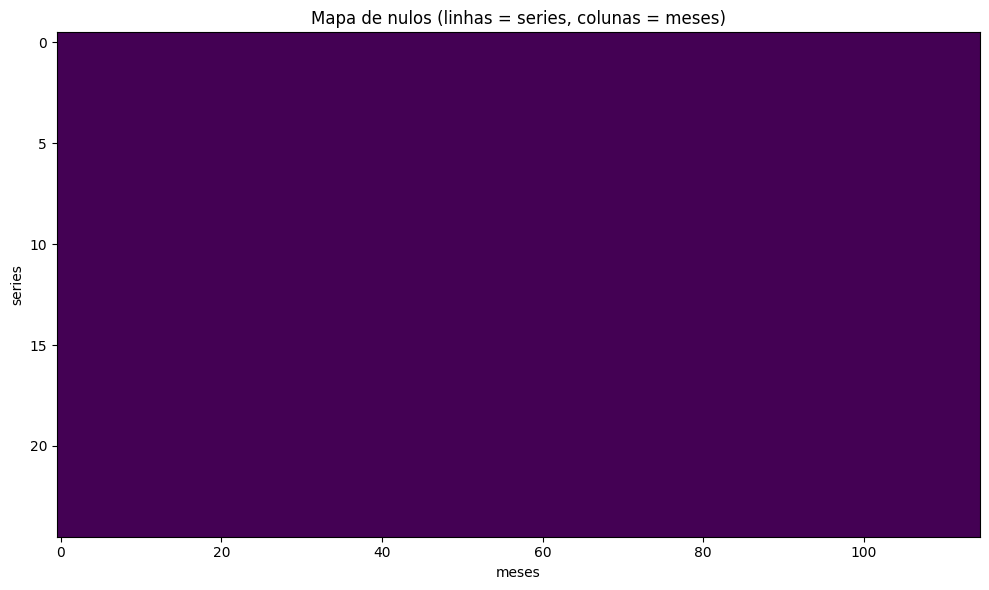

In [8]:
def relatorio_nulos(painel: pd.DataFrame) -> pd.DataFrame:
    n_meses = painel.shape[1]
    n_nulos = painel.isna().sum(axis=1)
    cobertura = (1 - n_nulos / n_meses) * 100.0
    out = pd.DataFrame({
        "n_meses": n_meses,
        "n_nulos": n_nulos,
        "cobertura_pct": cobertura.round(1)
    }).sort_values("cobertura_pct")
    out.index.name = "serie"
    return out

# tabela de nulos
rel_nulos = relatorio_nulos(painel)
display(rel_nulos)

# grafico de nulos (mapa simples)
plt.figure(figsize=(10, 6))
plt.imshow(painel.isna(), aspect="auto", interpolation="nearest")
plt.title("Mapa de nulos (linhas = series, colunas = meses)")
plt.xlabel("meses")
plt.ylabel("series")
plt.tight_layout()
plt.show()

# 📈 Correlação com as Séries-Alvo (Spreads)

### O que é correlação?
- É uma **medida estatística** que mostra **o quanto duas variáveis se relacionam**.  
- Vai de **-1 a +1**:  
  - **+1** = correlação perfeita positiva (sobem juntas).  
  - **-1** = correlação perfeita negativa (quando uma sobe, a outra cai).  
  - **0** = sem relação linear.

### No projeto de spreads
- As **séries-alvo** são os diferentes tipos de **spread bancário** (ex.: `spread_RL_PJ`, `spread_RD_TOT`).  
- A ideia é verificar quais variáveis (juros, concessões, ICC) têm maior relação com cada spread.  

### Exemplo de gráfico de correlação (heatmap)
- Cada célula mostra o **coeficiente de correlação**.  
- Cores quentes (vermelho) = correlação forte positiva.  
- Cores frias (azul) = correlação negativa.  

Esse gráfico ajuda a **visualizar de forma rápida quais variáveis explicam melhor os spreads**.

In [9]:
# listas das series-alvo 
spreads_alvo = [
    "spread_RD_PJ_20826",
    "spread_RD_PF_20837",
    "spread_RD_TOT_20825",
    "spread_RL_PJ_20787",
    "spread_RL_PF_20809",
    "spread_RL_TOT_20786",
]

# filtra apenas as que existem no painel
spreads_presentes = [s for s in spreads_alvo if s in painel.index]
if len(spreads_presentes) == 0:
    raise ValueError("Nenhuma das series de spread informadas foi encontrada no painel.")

def correlacoes_com_alvo(painel: pd.DataFrame, alvo: str, top_n: int = 15) -> pd.DataFrame:
    """
    Calcula correlacao de Pearson entre a serie 'alvo' (linha do painel)
    e todas as demais series, usando apenas os meses onde o 'alvo' tem dado.
    Retorna dataframe ordenado por |correlacao|.
    """
    # alvo como numerico
    s_alvo = pd.to_numeric(painel.loc[alvo], errors="coerce")
    # meses validos do alvo
    cols_validas = s_alvo.index[s_alvo.notna()]
    if len(cols_validas) < 3:
        return pd.DataFrame(columns=["corr", "abs"])

    # outras series como numerico, alinhadas nas mesmas colunas validas
    outros = painel.drop(index=[alvo], errors="ignore")
    outros = outros.loc[:, cols_validas].apply(pd.to_numeric, errors="coerce")

    # remove colunas com NaN no alvo (ja filtrado) e calcula correlacao
    corr = outros.T.corrwith(s_alvo.loc[cols_validas])
    corr = corr.dropna()
    res = pd.DataFrame({"corr": corr, "abs": corr.abs()}).sort_values("abs", ascending=False)
    return res.head(top_n)

# calcula e mostra as tabelas de correlacao para cada spread-alvo
tabelas_corr = {}
for alvo in spreads_presentes:
    print(f"\n=== Correlações com alvo: {alvo} ===")
    tab = correlacoes_com_alvo(painel, alvo, top_n=15)
    tabelas_corr[alvo] = tab
    display(tab)


=== Correlações com alvo: spread_RD_PJ_20826 ===


,corr,abs
spread_RD_TOT_20825,0.673288,0.673288
taxa_RD_PJ_20757,0.578839,0.578839
icc_RL_PJ_25355,0.572941,0.572941
spread_RL_TOT_20786,0.558174,0.558174
icc_RL_TOT_25354,0.556468,0.556468
taxa_RL_PF_20740,0.553623,0.553623
taxa_RL_TOT_20717,0.552714,0.552714
spread_RL_PF_20809,0.540649,0.540649
taxa_RL_PJ_20718,0.523682,0.523682
spread_RL_PJ_20787,0.519300,0.519300



=== Correlações com alvo: spread_RD_PF_20837 ===


,corr,abs
spread_RD_TOT_20825,0.587009,0.587009
taxa_RL_PJ_20718,-0.501058,0.501058
icc_RL_PJ_25355,-0.370948,0.370948
taxa_RL_TOT_20717,-0.367159,0.367159
spread_RL_PJ_20787,-0.351101,0.351101
taxa_RL_PF_20740,-0.339662,0.339662
selic_aa,-0.339045,0.339045
taxa_RD_PJ_20757,-0.326921,0.326921
icc_RL_TOT_25354,-0.293490,0.293490
icc_RL_PF_25356,-0.254058,0.254058



=== Correlações com alvo: spread_RD_TOT_20825 ===


,corr,abs
spread_RD_PJ_20826,0.673288,0.673288
spread_RD_PF_20837,0.587009,0.587009
icc_RD_PF_25359,0.369570,0.369570
spread_RL_TOT_20786,0.307456,0.307456
spread_RL_PF_20809,0.299864,0.299864
icc_RD_TOT_25357,0.295342,0.295342
icc_RL_TOT_25354,0.256495,0.256495
taxa_RD_TOT_20756,0.255799,0.255799
icc_RL_PF_25356,0.253618,0.253618
taxa_RL_PF_20740,0.234260,0.234260



=== Correlações com alvo: spread_RL_PJ_20787 ===


,corr,abs
spread_RL_PF_20809,0.939238,0.939238
icc_RL_PF_25356,0.938151,0.938151
spread_RL_TOT_20786,0.925340,0.925340
icc_RL_TOT_25354,0.899108,0.899108
icc_RL_PJ_25355,0.886130,0.886130
taxa_RL_PF_20740,0.872808,0.872808
taxa_RL_TOT_20717,0.809261,0.809261
taxa_RL_PJ_20718,0.795271,0.795271
concessoes_RL_PJ_20635,-0.638768,0.638768
concessoes_RD_PF_20698,-0.634666,0.634666



=== Correlações com alvo: spread_RL_PF_20809 ===


,corr,abs
spread_RL_TOT_20786,0.992998,0.992998
icc_RL_PF_25356,0.962567,0.962567
icc_RL_TOT_25354,0.960837,0.960837
taxa_RL_PF_20740,0.960664,0.960664
icc_RL_PJ_25355,0.945756,0.945756
spread_RL_PJ_20787,0.939238,0.939238
taxa_RL_TOT_20717,0.912195,0.912195
taxa_RL_PJ_20718,0.840979,0.840979
selic_aa,0.601542,0.601542
spread_RD_PJ_20826,0.540649,0.540649



=== Correlações com alvo: spread_RL_TOT_20786 ===


,corr,abs
spread_RL_PF_20809,0.992998,0.992998
icc_RL_TOT_25354,0.976889,0.976889
taxa_RL_PF_20740,0.963846,0.963846
icc_RL_PJ_25355,0.959933,0.959933
icc_RL_PF_25356,0.959216,0.959216
taxa_RL_TOT_20717,0.930385,0.930385
spread_RL_PJ_20787,0.925340,0.925340
taxa_RL_PJ_20718,0.853081,0.853081
selic_aa,0.632100,0.632100
taxa_RD_TOT_20756,0.558318,0.558318


## Área de teste

In [11]:
for alvo, tab in tabelas_corr.items():
    tab.to_csv(f"correlacoes_{alvo}.csv", encoding="utf-8-sig")
